## 데이터 가져오기

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [20]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 모델 정의

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_planes, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_planes, in_planes // r),
            nn.ReLU(),
            nn.Linear(in_planes // r, in_planes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.seblock = SEBlock(out_planes)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.seblock(out) * out
        return out

class MobileNet(nn.Module):
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10, width_mult=0.5):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, int(32 * width_mult), kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(int(32 * width_mult))
        self.layers = self._make_layers(in_planes=int(32 * width_mult), width_mult=width_mult)
        self.dropout = nn.Dropout(0.2)  # 마지막 완전 연결 레이어 전에 Dropout 추가
        self.linear = nn.Linear(int(1024 * width_mult), num_classes)

    def _make_layers(self, in_planes, width_mult):
        layers = []
        for x in self.cfg:
            out_planes = int(x[0] * width_mult) if isinstance(x, tuple) else int(x * width_mult)
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  # 완전 연결 레이어 전에 Dropout 적용
        out = self.linear(out)
        return out
model = MobileNet().to(device)
from torchsummary import summary
print("CNN's number of Parameters: ", sum([p.numel() for p in model.parameters()]))

summary(model,(3,28,28))

CNN's number of Parameters:  946820
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             432
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]             144
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 32, 28, 28]             512
       BatchNorm2d-6           [-1, 32, 28, 28]              64
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Linear-8                    [-1, 2]              66
              ReLU-9                    [-1, 2]               0
           Linear-10                   [-1, 32]              96
          Sigmoid-11                   [-1, 32]               0
          SEBlock-12             [-1, 32, 1, 1]               0
            Block-13           [-1, 32, 28, 28]               0
   

In [22]:
!pip install ptflops
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       13.13 MMac
Number of parameters:           946.82 k


## 손실함수 정의

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)

## 학습

In [24]:
def model_train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device),data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 6400==0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

## 검증 및 평가

In [25]:
def model_evaluate():
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data[0].to(device),data[1].to(device)
      outputs = model(images)
      test_loss += F.cross_entropy(outputs, labels, reduction = "sum").item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_loss /= len(testloader.dataset)
  test_accuracy = 100. * correct / len(testloader.dataset)
  return test_loss,test_accuracy

In [26]:
INPUT_EPOCHS = 100
losses = []
accuracies = []
for epoch in range(INPUT_EPOCHS):
  model_train(epoch)
  test_loss , test_accuracy = model_evaluate()
  losses.append(test_loss)
  accuracies.append(test_accuracy)
  print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch+1, test_loss, test_accuracy))

[1,     1] loss: 0.001
[1] Test Loss: 1.3865, accuracy: 49.44%

[2,     1] loss: 0.001
[2] Test Loss: 1.1529, accuracy: 58.43%

[3,     1] loss: 0.001
[3] Test Loss: 1.0259, accuracy: 63.78%

[4,     1] loss: 0.001
[4] Test Loss: 0.9094, accuracy: 67.86%

[5,     1] loss: 0.000
[5] Test Loss: 0.8047, accuracy: 72.11%

[6,     1] loss: 0.000
[6] Test Loss: 0.7779, accuracy: 73.35%

[7,     1] loss: 0.000
[7] Test Loss: 0.7043, accuracy: 75.24%

[8,     1] loss: 0.000
[8] Test Loss: 0.6708, accuracy: 76.99%

[9,     1] loss: 0.000
[9] Test Loss: 0.6280, accuracy: 78.25%

[10,     1] loss: 0.000
[10] Test Loss: 0.6413, accuracy: 78.00%

[11,     1] loss: 0.000
[11] Test Loss: 0.5908, accuracy: 79.53%

[12,     1] loss: 0.000
[12] Test Loss: 0.6051, accuracy: 79.36%

[13,     1] loss: 0.000
[13] Test Loss: 0.5867, accuracy: 79.88%

[14,     1] loss: 0.000
[14] Test Loss: 0.5525, accuracy: 81.39%

[15,     1] loss: 0.000
[15] Test Loss: 0.5901, accuracy: 80.22%

[16,     1] loss: 0.000
[16]

## 그래프 그리기

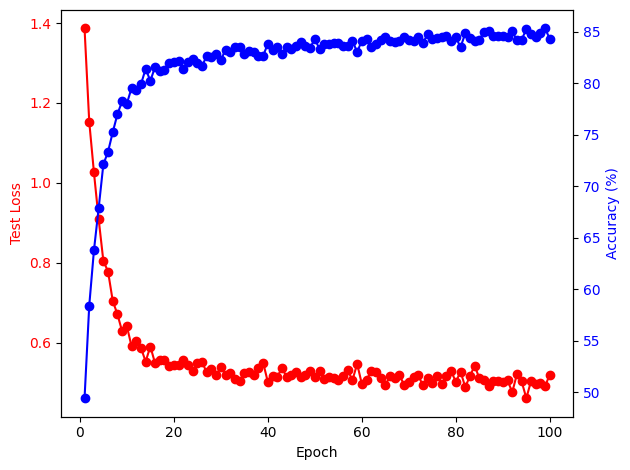

In [27]:

import matplotlib.pyplot as plt
def draw_graph(losses,accuracies,x):
  x_epochs = range(1, x + 1)
  # 그래프 생성
  fig, ax1 = plt.subplots()

  # 첫 번째 Y축 (losses)
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Test Loss', color='red')
  ax1.plot(x_epochs, losses, 'r-o')
  ax1.tick_params(axis='y', labelcolor='red')

  # 두 번째 Y축 (accuracies)
  ax2 = ax1.twinx()  # 같은 X축을 공유하는 두 번째 Y축 생성
  ax2.set_ylabel('Accuracy (%)', color='blue')
  ax2.plot(x_epochs, accuracies, 'b-o')
  ax2.tick_params(axis='y', labelcolor='blue')

  # 그래프 표시
  fig.tight_layout()
  plt.show()
draw_graph(losses,accuracies,INPUT_EPOCHS)

In [28]:
torch.save(model.state_dict(), 'B815083_model.pkt')

In [29]:
model2 = MobileNet().to(device)
model2.load_state_dict(torch.load('B815083_model.pkt'))

<All keys matched successfully>